In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load processed data
df = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")

df["year"] = pd.to_datetime(df["observation_date"], errors="coerce").dt.year

num_df = df[df["value_numeric"].notna()].copy()

wide_df = num_df.pivot_table(
    index="year",
    columns="indicator",
    values="value_numeric",
    aggfunc="mean"
).reset_index()

wide_df = wide_df.rename(columns={
    "Account Ownership Rate": "account_ownership",
    "4G Population Coverage": "fourg_coverage",
    "Mobile Money Account Rate": "mobile_money_rate"
})

wide_df = wide_df.sort_values("year").ffill()

driver_df = wide_df[
    ["year", "account_ownership", "fourg_coverage", "mobile_money_rate"]
].dropna()

X = driver_df[["fourg_coverage", "mobile_money_rate"]]
y = driver_df["account_ownership"]

driver_model = LinearRegression()
driver_model.fit(X, y)

driver_model.coef_, driver_model.intercept_


(array([0.63063063, 0.63157895]), np.float64(19.38293029871975))

In [3]:
baseline = driver_df.sort_values("year").iloc[-1]

baseline_inputs = pd.DataFrame([{
    "fourg_coverage": baseline["fourg_coverage"],
    "mobile_money_rate": baseline["mobile_money_rate"]
}])

baseline_prediction = driver_model.predict(baseline_inputs)[0]

baseline_inputs, baseline_prediction


(   fourg_coverage  mobile_money_rate
 0            70.8               9.45,
 np.float64(70.0))

In [4]:
scenarios = pd.DataFrame([
    {
        "scenario": "Baseline",
        "fourg_coverage": baseline["fourg_coverage"],
        "mobile_money_rate": baseline["mobile_money_rate"]
    },
    {
        "scenario": "Moderate Expansion",
        "fourg_coverage": baseline["fourg_coverage"] + 10,
        "mobile_money_rate": baseline["mobile_money_rate"] + 5
    },
    {
        "scenario": "Aggressive Digital Push",
        "fourg_coverage": baseline["fourg_coverage"] + 20,
        "mobile_money_rate": baseline["mobile_money_rate"] + 10
    }
])

scenarios


,scenario,fourg_coverage,mobile_money_rate
0,Baseline,70.8,9.45
1,Moderate Expansion,80.8,14.45
2,Aggressive Digital Push,90.8,19.45


In [5]:
scenarios["predicted_account_ownership"] = driver_model.predict(
    scenarios[["fourg_coverage", "mobile_money_rate"]]
)

scenarios


,scenario,fourg_coverage,mobile_money_rate,predicted_account_ownership
0,Baseline,70.8,9.45,70.000000
1,Moderate Expansion,80.8,14.45,79.464201
2,Aggressive Digital Push,90.8,19.45,88.928402


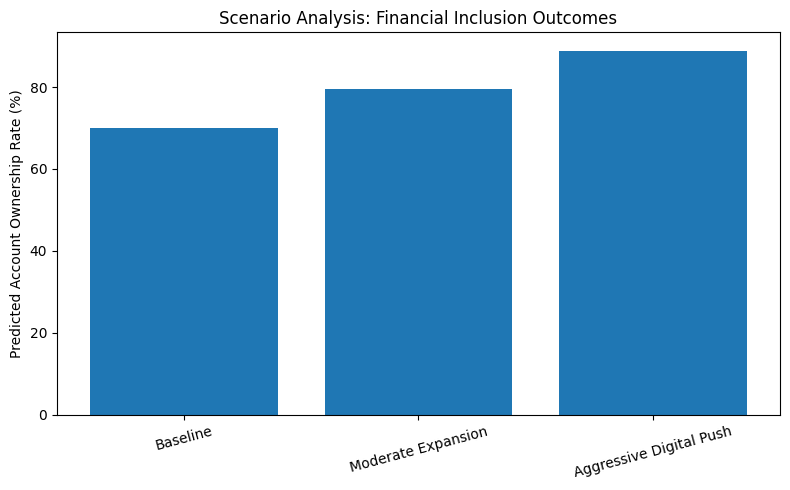

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(
    scenarios["scenario"],
    scenarios["predicted_account_ownership"]
)

plt.ylabel("Predicted Account Ownership Rate (%)")
plt.title("Scenario Analysis: Financial Inclusion Outcomes")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
